# Ben E Keith COVID Analysis

Goal: 
1. Process BEK data (source = data.attribytes.com)
2. Analyze data using COVID segmentation
3. Compare sell-out (Ben E Keith) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import teradatasql

from distributor_transformation import transform_bek
from sellout_model import process_list, analyze, add_time
from sellout_teradata import teradata_sales
from sellout_import import import_bek, all_df
from sellout_azure import azure_sellin

# Import portal raw file

In [2]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
file_name = 'BEK Update.xls'

df = import_bek(file_path + file_name)

C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\BEK Update.xls


### 7. Apply Dictionary to Raw Data / Check For Missing Segmentation
Run cell below

In [3]:
df_bek = transform_bek(df, 'BEK - US.xlsx')

Shape before adding dictionary: (256302, 23)
Shape after adding segmentation: (256302, 29)
Shape after adding product segmentation: (256302, 32)
Shape before adding time: (256302, 33)
Shape after adding time: (256302, 34)
Shape after adding dictionary: (256298, 35)
Nothing missing for COVID Segmentation - L1
The following products are missing:
                       Group       Family      SKU ID  Prod Nbr   
0  FV560 POTATO, CRINKLE CUT  Frozen Food  1000012013  201486.0  \

                          Product Product Ext.Description Pack / Size    LBS  
0  French Fries Cc Signature Coat             Sonic 68328    6 / 6 Lb  936.0  


In [4]:
df_bek['Week Starting'].max()

Timestamp('2024-04-07 00:00:00')

### 8. Combine New and Base Datasets
Run cell below

In [5]:
backup_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\Backups\\'

_base = all_df(df_bek, backup_path, 'BEK.csv')

Imported shape...(256298, 35)
Final shape...(3489482, 13)


### 9. Execute Analysis
Run cell below

In [6]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City','State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

#Output 2: COVID L1 - List 1
_list.append(['State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','SKU ID','Consolidated Category','L1 Product Hierarchy','L2 Product Hierarchy'])

#Create dataframes
print(f'Processing Segments', flush = True)
output1 = process_list(_base, _list[0], 'Ben E Keith')

#print(f'Processing Sell in vs Sell out', flush = True)
#output2 = teradata_sales(_base, '6500002764', 'Ben E Keith')

Processing Segments


In [7]:
print(f'Processing Sell in vs Sell out', flush = True)
output2 = azure_sellin(_base, 'US01', "','".join(['6500002764']), 'Ben E Keith')

print('All done')

Processing Sell in vs Sell out
Query ran for 6500002764 under sales org US01 for sales on or before 2024-04-14
All done, took 67.0 seconds...
All done


In [8]:
output1.to_csv('files/sellout_region_bek.zip', compression='zip', index=False)
output2.to_csv('files/sellout_sellin_bek.zip', compression='zip', index=False)

In [9]:
_base.to_csv(backup_path + 'BEK.csv')

In [13]:
output1['COVID Segmentation - L1'].value_counts()

Recreation                      22344
Casual Dining                   16268
QSR / Fast Casual               13720
Bars & Pubs                     12740
Grocery - Convenience           10192
Healthcare                       9800
Schools & Education              9800
Public Sector (On site)          8428
Distributor / Other Accounts     6272
Workplace Canteens               5684
Accommodation                    4704
Name: COVID Segmentation - L1, dtype: int64

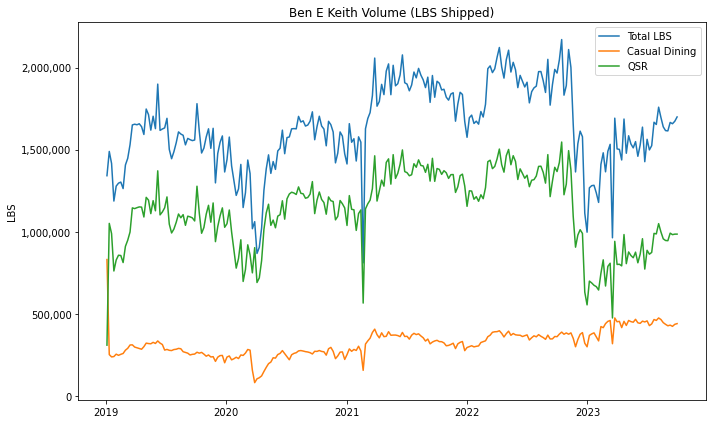

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

fig, ax = plt.subplots()

graph_data = output1.groupby(['Week Ending (Sat)','COVID Segmentation - L1'])['LBS'].sum().reset_index()

ax.plot('Week Ending (Sat)','LBS', data=graph_data.groupby('Week Ending (Sat)').sum().reset_index())
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='Casual Dining'])
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='QSR / Fast Casual'])

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Total LBS', 'Casual Dining', 'QSR'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('LBS')

ax.set_title(f'Ben E Keith Volume (LBS Shipped)')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

In [8]:
output1.columns

Index(['City', 'State Name', 'COVID Segmentation - L1',
       'COVID Segmentation - L2', 'Restaurant Service Type',
       'Consolidated Category', 'Calendar Week Year', 'Distributor', 'LBS',
       'SMA_4', 'SMA_8', 'SMA_12', 'YOY Week', 'LBS_LY', 'SMA_4_LY',
       'SMA_8_LY', 'SMA_12_LY', 'Baseline Week', 'LBS_Baseline',
       'SMA_4_Baseline', 'SMA_8_Baseline', 'SMA_12_Baseline', 'LBS_Lag_1',
       'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Baseline_Lag_1',
       'LBS_LY_Lag_1', 'SMA_4_Lag_1', 'SMA_4_LY_Lag_1', 'SMA_4_Baseline_Lag_1',
       'LBS_PRECOVID', 'Week Starting (Sun)', 'Week Ending (Sat)',
       'COVID Week'],
      dtype='object')

In [1]:
fig, ax = plt.subplots()

graph_data = output1[output1['Consolidated Category']=='Prepared Foods'].groupby(['Week Ending (Sat)','COVID Segmentation - L1'])['LBS'].sum().reset_index()

#graph_data = graph_data[graph_data['Consolidated Category']=='Prepared Foods']

ax.plot('Week Ending (Sat)','LBS', data=graph_data.groupby('Week Ending (Sat)').sum().reset_index())
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='Casual Dining'])
ax.plot('Week Ending (Sat)','LBS', data=graph_data[graph_data['COVID Segmentation - L1']=='QSR / Fast Casual'])

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Total LBS', 'Casual Dining', 'QSR'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('LBS')

ax.set_title(f'Ben E Keith Volume (LBS Shipped)')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

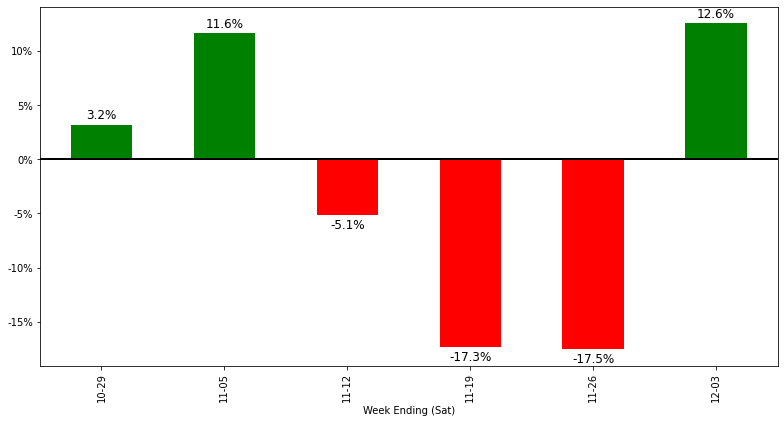

In [84]:

fig, ax = plt.subplots()

data = output1.groupby('Week Ending (Sat)')['LBS'].sum().pct_change()[-6:]

#4 week change
#data = output1[output1['COVID Segmentation - L1']=='Casual Dining'].groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=4)[-6:]
#data = output1[output1['COVID Segmentation - L1']=='QSR / Fast Casual'].groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=4)[-6:]

#establish colors for values
col = []
for val in data:
    if val < 0:
        col.append('red')
    elif val >= 0:
        col.append('green')
    else:
        col.append('white')
        
#data = data * 100

ax = data.plot(kind='bar', ax=ax, color = col)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

#x-ticks
x_ticks = output1['Week Ending (Sat)'].dt.strftime('%m-%d').unique()[-6:]
x_range = np.arange(len(x_ticks))
plt.xticks(x_range, x_ticks)

#for container in ax.containers:
#    ax.bar_label(container, fmt='%0.2f%%', padding=3)

lbls = (data.values * 100).round(1)

lbls = [f'{l}%' for l in lbls]

annotations = ax.bar_label(ax.containers[0], labels = lbls,  fmt='%.1f%%', padding=3, label_type='edge', fontsize=12)

ax.hlines(y=0, xmin=-10, xmax=10, linewidth=2, color='black')

fig.set_size_inches((11, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

<AxesSubplot:xlabel='Week Ending (Sat)'>

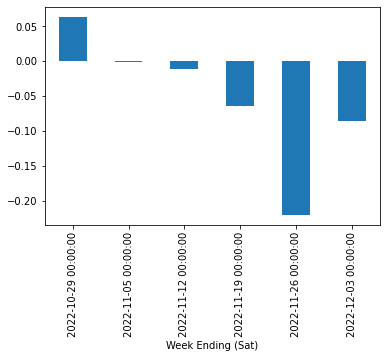

In [13]:
output1[output1['COVID Segmentation - L1']=='Casual Dining'].groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=4)[-6:].plot(kind='bar')

<AxesSubplot:xlabel='Week Ending (Sat)'>

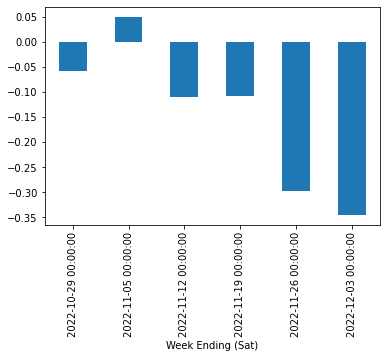

In [12]:
output1[output1['COVID Segmentation - L1']=='QSR / Fast Casual'].groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=4)[-6:].plot(kind='bar')

In [9]:
output1.columns

Index(['City', 'State Name', 'COVID Segmentation - L1',
       'COVID Segmentation - L2', 'Restaurant Service Type',
       'Consolidated Category', 'Calendar Week Year', 'Distributor', 'LBS',
       'SMA_4', 'SMA_8', 'SMA_12', 'YOY Week', 'LBS_LY', 'SMA_4_LY',
       'SMA_8_LY', 'SMA_12_LY', 'Baseline Week', 'LBS_Baseline',
       'SMA_4_Baseline', 'SMA_8_Baseline', 'SMA_12_Baseline', 'LBS_Lag_1',
       'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Baseline_Lag_1',
       'LBS_LY_Lag_1', 'SMA_4_Lag_1', 'SMA_4_LY_Lag_1', 'SMA_4_Baseline_Lag_1',
       'LBS_PRECOVID', 'Week Starting (Sun)', 'Week Ending (Sat)',
       'COVID Week'],
      dtype='object')

<AxesSubplot:xlabel='Calendar Week Year,Distributor'>

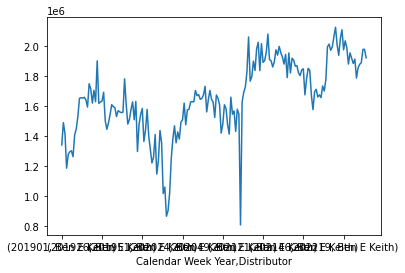

In [18]:
output1.groupby(['Calendar Week Year','Distributor'])['LBS'].sum().plot()

In [19]:
output1.groupby(['Calendar Week Year','Distributor'])['LBS'].sum()

Calendar Week Year  Distributor
201901              Ben E Keith    1341492.22
201902              Ben E Keith    1489358.30
201903              Ben E Keith    1416016.70
201904              Ben E Keith    1187008.76
201905              Ben E Keith    1278096.08
                                      ...    
202229              Ben E Keith    1876876.16
202230              Ben E Keith    1887312.74
202231              Ben E Keith    1975866.68
202232              Ben E Keith    1976353.40
202233              Ben E Keith    1920357.44
Name: LBS, Length: 190, dtype: float64

In [7]:
output1['Week Ending (Sat)'].max()

Timestamp('2022-07-23 00:00:00')

### 10. Upload Analysis to Teradata
Run cell below

In [6]:
def td_upload(select_db, df, table_name):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            d = dt.now().strftime('%m/%d/%Y %H:%M:%S %p')
            print(f'Database selected! {d}', flush=True)            

            delete_from_td(df, table_name, cur)
            insert_into_td(df, table_name, cur)

def delete_from_td(df, table_name, cur):
    distributor = df.groupby('Distributor').size().reset_index().drop(columns=0).to_numpy()[0][0]
    
    print(f'Deleting records for: {distributor} in table: {table_name}', flush = True)          
    
    query = '''
    DELETE FROM ''' + table_name  + ''' 
    WHERE "Distributor" = ''' + "'" + distributor + "'" + ''' AND "Calendar Week Year" IN (''' + include + ")"
    
    #query = '''
    #DELETE FROM ''' + table_name  + ''' 
    #WHERE "Distributor" = ''' + "'" + distributor + "'"
    
    cur.execute (query)
    
def insert_into_td(df, table_name, cur):
    insert_list = df.values.tolist()
    
    #creates ?, ?,.... string used in query for teradata fastload
    insert_columns = ('?, ' * len(df.columns)).rstrip(', ')
    
    print(f'Inserting records into {table_name}', flush = True)
    
    query = "INSERT INTO " + table_name  + " (" + insert_columns + ")"
    #query = "{fn teradata_try_fastload}INSERT INTO " + table_name  + " (" + insert_columns + ")"
    
    cur.execute (query, insert_list)
    
    print(f'Inserted {df.shape[0]} records', flush = True)
    

select_db = 'DATABASE DL_NA_PROTOTYPING'

exclude_list = output1['Calendar Week Year'].sort_values(ascending=False).unique().tolist()[:6]
include = str(exclude_list)[1:-1]

#only send new data
td_upload(select_db, output1[output1['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_REGION')
td_upload(select_db, output2[output2['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_AND_SELLIN')

#only send all data
#td_upload(select_db, output1, 'SELLOUT_REGION')
#td_upload(select_db, output2, 'SELLOUT_AND_SELLIN')

#td_upload(select_db, output3[output3['Calendar Week Year'].isin(exclude_list)].astype({'SKU ID':'str'}), 'SELLOUT_REGION_SKU')

Database selected! 07/19/2022 15:44:09 PM
Deleting records for: Ben E Keith in table: SELLOUT_REGION
Inserting records into SELLOUT_REGION
Inserted 3648 records
Database selected! 07/19/2022 15:44:17 PM
Deleting records for: Ben E Keith in table: SELLOUT_AND_SELLIN
Inserting records into SELLOUT_AND_SELLIN
Inserted 12 records


# Import into SQL mi server

In [3]:
import pandas as pd

In [2]:
def convert_to_dataframe(file_path):

    if file_path.endswith('.csv'):
            df = pd.read_csv(file_name, thousands = ',', encoding="utf-8", low_memory = False, header = 0,na_values = " ")
            df = df[df['Branch'] != 'Total']
    else:
        df = pd.DataFrame()

        _import = pd.read_excel(file_path, sheet_name=None)
        
        for f in _import:
            if f == 'Sheet1':
                add = pd.DataFrame.from_dict(_import[f])
                
                col = add.columns.to_list()
            else:
                add = _import[f].T.reset_index().T
                add.columns = col
        
            df = pd.concat([df, add])
        
        df = df.rename(columns={
            'Unnamed: 21':'LBS',
            'Unnamed: 22':'LBS'
            })

    return df

In [3]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\2024-04-12\BEK Update.xls'
bek = convert_to_dataframe(file_path)

In [4]:
bek.columns

Index(['Branch', 'Business Unit', 'SIC Code', 'SIC Sub', 'Customer Nbr.',
       'Customer Name', 'Customer Address1', 'Customer Address2',
       'Customer City', 'Customer State', 'Customer Zip', 'Family', 'Brand',
       'Group', 'Manufacture Prod.Nbr.', 'Prod Nbr', 'Product', 'Prod Nbr.1',
       'Pack / Size', 'Product Ext.Description', 'Week of', 'Month', 'LBS'],
      dtype='object')

In [19]:
columns_to_keep = ['Branch', 'Business Unit', 'SIC Code', 'SIC Sub', 'Customer Nbr.',
       'Customer Name', 'Customer Address1', 'Customer Address2',
       'Customer City', 'Customer State', 'Customer Zip', 'Manufacture Prod.Nbr.', 'Prod Nbr', 'Product', 'Week of', 'LBS']

rename_columns = {
    'Customer Nbr.':'Customer Number',
    'Manufacture Prod.Nbr.':'McCain SKU ID',
    'Prod Nbr':'Product Number',
    'Product':'Product Description',
    'Week of':'Week Beginning Date'
}

nan_rows = bek[bek['Week of'].isna()].index

bek_clean = bek[columns_to_keep].rename(columns=rename_columns).drop(nan_rows)

columns_to_clean = ['Customer Number','Customer Zip','Product Number']

for col in columns_to_clean:
    bek_clean[col] = bek_clean[col].astype(int).astype(str)

bek_clean['LBS'] = bek_clean['LBS'].astype(float)

bek_clean['Week Beginning Date'] = pd.to_datetime(bek_clean['Week Beginning Date'])

bek_clean.head()

,Branch,Business Unit,SIC Code,SIC Sub,Customer Number,Customer Name,Customer Address1,Customer Address2,Customer City,Customer State,Customer Zip,McCain SKU ID,Product Number,Product Description,Week Beginning Date,LBS
1,NEW MEXICO,NATIONAL,RESTAURANTS,HAMBURGER,874113,MOOYAH BURGER 252 EL PASO,8889 GATEWAY BLVD. STE 45,NaN,EL PASO,TX,79925,MCF03731,363445,Potato Sweet Fries 5/16 In,2023-12-31,210.0
2,NEW MEXICO,NATIONAL,RESTAURANTS,HAMBURGER,874113,MOOYAH BURGER 252 EL PASO,8889 GATEWAY BLVD. STE 45,NaN,EL PASO,TX,79925,MCF03731,363445,Potato Sweet Fries 5/16 In,2024-01-07,210.0
3,NEW MEXICO,NATIONAL,RESTAURANTS,HAMBURGER,874113,MOOYAH BURGER 252 EL PASO,8889 GATEWAY BLVD. STE 45,NaN,EL PASO,TX,79925,MCF03731,363445,Potato Sweet Fries 5/16 In,2024-01-14,180.0
4,NEW MEXICO,NATIONAL,RESTAURANTS,HAMBURGER,874113,MOOYAH BURGER 252 EL PASO,8889 GATEWAY BLVD. STE 45,NaN,EL PASO,TX,79925,MCF03731,363445,Potato Sweet Fries 5/16 In,2024-01-21,150.0
5,NEW MEXICO,NATIONAL,RESTAURANTS,HAMBURGER,874113,MOOYAH BURGER 252 EL PASO,8889 GATEWAY BLVD. STE 45,NaN,EL PASO,TX,79925,MCF03731,363445,Potato Sweet Fries 5/16 In,2024-02-04,210.0


In [22]:
import os

# The path to the directory containing the folders
directory_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files'

# Get a list of all entries in the directory
entries = os.listdir(directory_path)

# Filter the list to include only directories, not files
directories = [d for d in entries if os.path.isdir(os.path.join(directory_path, d))]

# Sort the directories by their names, assuming they are in 'yyyy-mm-dd' format
sorted_directories = sorted(directories, key=lambda x: x)

# Loop through the sorted directories
for folder in sorted_directories:
    print(f"Processing folder: {folder}")

Processing folder: 2020-11-13
Processing folder: 2020-11-20
Processing folder: 2020-12-04
Processing folder: 2020-12-11
Processing folder: 2020-12-18
Processing folder: 2021-01-08
Processing folder: 2021-01-15
Processing folder: 2021-01-22
Processing folder: 2021-01-29
Processing folder: 2021-02-05
Processing folder: 2021-02-12
Processing folder: 2021-02-19
Processing folder: 2021-02-26
Processing folder: 2021-03-05
Processing folder: 2021-03-12
Processing folder: 2021-03-19
Processing folder: 2021-03-26
Processing folder: 2021-04-09
Processing folder: 2021-04-16
Processing folder: 2021-04-23
Processing folder: 2021-04-30
Processing folder: 2021-05-05
Processing folder: 2021-05-14
Processing folder: 2021-05-21
Processing folder: 2021-05-28
Processing folder: 2021-06-04
Processing folder: 2021-06-11
Processing folder: 2021-06-18
Processing folder: 2021-06-25
Processing folder: 2021-07-02
Processing folder: 2021-07-09
Processing folder: 2021-07-16
Processing folder: 2021-07-23
Processing

In [11]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from datetime import datetime
import pandas as pd

class bek_sellout:
    def __init__(self, file_path) -> None:
        self.filepath = file_path
        self.data = self.process_file()
        self.data_import = self.filter_rows()
        #self.delete_rows()
        self.insert_rows()

        pass
    
    def transform_data(df):
        columns_to_keep = ['Branch', 'Business Unit', 'SIC Code', 'SIC Sub', 
                           'Customer Nbr.','Customer Name', 'Customer Address1', 'Customer Address2',
                           'Customer City', 'Customer State', 'Customer Zip', 'Manufacture Prod.Nbr.', 
                           'Prod Nbr', 'Product', 'Week of', 'LBS']

        rename_columns = {
            'Customer Nbr.':'Customer Number',
            'Manufacture Prod.Nbr.':'McCain SKU ID',
            'Prod Nbr':'Product Number',
            'Product':'Product Description',
            'Week of':'Week Beginning Date'
        }

        nan_rows = df[df['Week of'].isna()].index

        df_clean = df[columns_to_keep].rename(columns=rename_columns).drop(nan_rows)

        columns_to_clean = ['Customer Number','Customer Zip','Product Number']

        for col in columns_to_clean:
            df_clean[col] = df_clean[col].astype(str)
            df_clean[col] = df_clean[col].str.replace(r'\.0$', '', regex=True)
            
        df_clean['LBS'] = df_clean['LBS'].astype(float)

        df_clean['Week Beginning Date'] = pd.to_datetime(df_clean['Week Beginning Date'])

        return df_clean
    
    def process_file(self):
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_name, thousands = ',', encoding="utf-8", low_memory = False, header = 0,na_values = " ")
            df = df[df['Branch'] != 'Total']
        else:
            df = pd.DataFrame()

            _import = pd.read_excel(file_path, sheet_name=None)
            
            for f in _import:
                if f == 'Sheet1':
                    add = pd.DataFrame.from_dict(_import[f])
                    
                    col = add.columns.to_list()
                else:
                    add = _import[f].T.reset_index().T
                    add.columns = col
            
                df = pd.concat([df, add])

            df = df.rename(columns={
                'Unnamed: 16':'LBS',
                'Unnamed: 17':'LBS',
                'Unnamed: 18':'LBS',
                'Unnamed: 19':'LBS',
                'Unnamed: 20':'LBS',
                'Unnamed: 21':'LBS',
                'Unnamed: 22':'LBS',
                'Unnamed: 23':'LBS'
                })

        return bek_sellout.transform_data(df)

    def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor

    def delete_rows(self):
        # Get the unique dates as strings
        unique_dates = bek.data['Week Beginning Date'].dt.strftime('%Y-%m-%d').unique()

        # Convert the array of unique dates to a list of strings
        # Changed due to error received
        #date_strings = [f"'{date}'" for date in unique_dates]

        # Convert the results into a list of datetime objects
        # Adjust the format string as per your date format in the database
        dates_in_db = [datetime.strptime(result[0], '%Y-%m-%d') if result[0] is not None else None for result in results]

        # If you want to create a string that can be directly used in a SQL query
        dates_for_sql = ', '.join(date_strings)

        sql_delete = """
        DELETE FROM [na_dist].[US_BEK_Sellout] 
        WHERE [Week Beginning Date] IN (""" + dates_for_sql + """);"""

        cnxn, cursor = bek_sellout.setup_connection()

        cursor.execute(sql_delete)

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()


    def filter_rows(self):
        sql_select = """
        SELECT [Week Beginning Date] 
        FROM [na_dist].[US_BEK_Sellout]
        GROUP BY [Week Beginning Date] """

        cnxn, cursor = bek_sellout.setup_connection()

        cursor.execute(sql_select)

        # Fetch the results
        results = cursor.fetchall()

        # Convert the results into a list of dates
        dates_in_db = [result[0] if result[0] is not None else None for result in results]
        dates_in_db = pd.to_datetime([date for date in dates_in_db if date is not None])

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()

        return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]

    def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        engine = create_engine(conn_str, connect_args={"autocommit": True}, fast_executemany=True, use_insertmanyvalues=False)

        return engine

        
    def insert_rows(self):
        engine = bek_sellout.setup_miengine()

        table_name = 'US_BEK_Sellout'
        schema_name = 'na_dist'

        # If the table doesn't exist, it will be created automatically
        self.data_import.to_sql(table_name, con=engine, schema=schema_name, if_exists='append', index=False)



## Individual Files

In [12]:

file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-04-19\BEK Update.xls'

bek_sellout(file_path)

In [ ]:
#Legacy Files
#C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update 2019-1.xls - Done
#C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update 2019-2.xls - Done
#C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update 2019-3.xls - Done
#C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update 2020-1.xls - Done
#C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update 2020-2.xls - Having issues

## Directory - Batch Processing

In [53]:
import os

# The path to the directory containing the folders
directory_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files'

# Loop through each folder and file in the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if "SharedTable_weekly_cases" is in the filename
        if "BEK Update.xls" in file:

            # Construct the full file path
            file_path = os.path.join(root, file)
            
            print(file_path)

            bek_sellout(file_path)

C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2020-11-13\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2020-11-20\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-01-22\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-02-26\Data Files\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-09\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-23\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-04-30\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-05-05\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-05-14\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-05-28\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-06-04\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-06-11\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-06-18\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-06-25\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-07-09\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-07-16\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-07-23\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-07-30\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-08-06\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-08-13\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-08-20\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-08-27\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-09-03\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-09-10\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-09-17\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-09-24\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-09-31\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-10-08\Data Sources\BEK Update.xlsx


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-10-15\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-10-22\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-10-29\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-11-05\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-11-12\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-11-19\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-12-03\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-12-10\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2021-12-17\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-01-07\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-01-14\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-01-21\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-01-28\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-02-04\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-02-11\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-02-17\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-02-25\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-03-04\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-03-11\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-03-18\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-03-25\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-04-01\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-04-08\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-04-15\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-04-22\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-04-29\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-05-06\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-05-13\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-05-20\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-05-27\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-06-03\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-06-10\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-06-17\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-06-24\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-07-01\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-07-08\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-07-15\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-07-22\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-07-29\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-08-05\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-08-19\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-08-26\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-09-02\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-09-09\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-09-16\Data Source\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-09-23\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-09-30\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-10-07\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-10-14\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-10-21\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-10-28\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-11-04\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-11-11\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-11-18\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-11-25\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-12-02\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-12-09\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-12-16\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2022-12-23\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-01-06\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-01-13\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-01-20\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-01-27\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-02-03\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-02-10\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-02-17\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-02-24\Data Sources\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-03-03\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-03-10\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-03-17\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-03-24\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-03-31\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-04-07\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-05-05\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-05-12\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-05-19\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-05-26\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-06-02\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-06-09\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-06-16\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-06-23\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-07-07\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-07-14\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-07-21\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-07-28\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-08-04\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-08-11\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-08-18\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-08-25\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-09-01\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-09-08\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-09-15\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-09-22\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-09-29\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-10-06\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-10-13\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-10-20\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-10-27\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-11-03\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-11-10\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-11-17\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-12-01\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-12-08\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2023-12-15\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-01-05\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-01-12\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-01-19\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-01-26\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-02-02\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-02-09\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-02-16\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-02-23\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-03-01\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-03-08\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-03-15\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-03-22\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-04-05\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files\2024-04-12\BEK Update.xls


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_27072\626213147.py:148: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]


# BEK Dictionary

In [60]:
class bek_dictionary:
    def __init__(self, file_path) -> None:
        self.filepath = file_path
        self.data = self.process_file()
        self.delete_rows()
        self.insert_rows()

        pass
    

    def process_file(self):
        df = pd.read_excel(self.filepath, sheet_name='Segment Mapping')

        columns_to_keep = [
            'Business Unit',
            'SIC Code',
            'SIC Sub',
            'COVID Segmentation - L1',	
            'COVID Segmentation - L2',
            'COVID Segmentation - (Restaurants)',
            'COVID Segmentation - (Restaurants: Sub-Segment)',
            'Restaurant Service Type',
            'Cuisine Type'
        ]

        rename_columns = {
            'COVID Segmentation - L1':'Segmentation L1',
            'COVID Segmentation - L2':'Segmentation L2',
            'COVID Segmentation - (Restaurants)':'Restaurants',
            'COVID Segmentation - (Restaurants: Sub-Segment)':'Restaurants Sub',
            'Restaurant Service Type':'Service Type'
        }
        
        df_clean = df[columns_to_keep].rename(columns=rename_columns)

        return df_clean

    def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor

    def delete_rows(self):

        sql_delete = """
        DELETE FROM [na_dist].[US_BEK_Segmentation] 
        """

        cnxn, cursor = bek_dictionary.setup_connection()

        cursor.execute(sql_delete)

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()


    def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        engine = create_engine(conn_str, connect_args={"autocommit": True}, fast_executemany=True, use_insertmanyvalues=False)

        return engine

        
    def insert_rows(self):
        engine = bek_dictionary.setup_miengine()

        table_name = 'US_BEK_Segmentation'
        schema_name = 'na_dist'

        # If the table doesn't exist, it will be created automatically
        self.data.to_sql(table_name, con=engine, schema=schema_name, if_exists='append', index=False)

In [61]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Data Dictionaries\BEK - US.xlsx'

bek_dictionary(file_path)